In [2]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification,DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, precision_recall_curve, auc
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
data = pd.read_csv("dataset/Kaggle.csv")
model_dir ='models/BERT/Kaggle/'

# KAGGLE

In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Load and prepare the dataset
data = pd.read_csv("dataset/Kaggle.csv")  # Replace with your actual file path
print("Dataset head:\n", data.head())

# Extract relevant columns
tweets = data["tweet"].tolist()
labels = data["class"].tolist()  # 0: hate speech, 1: offensive language, 2: neither

# Check class distribution
print(f"Total samples: {len(tweets)}")
print(f"Hate speech (0): {sum(1 for l in labels if l == 0)}")
print(f"Offensive language (1): {sum(1 for l in labels if l == 1)}")
print(f"Neither (2): {sum(1 for l in labels if l == 2)}")

# Split into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(tweets, labels, test_size=0.3, stratify=labels, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


Dataset head:
    Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
Total samples: 24783
Hate speech (0): 1430
Offensive language (1): 19190
Neither (2): 4163


In [5]:
class TweetDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_length=128):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(tweet, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }


In [6]:

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Move to device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Prepare datasets
train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:


# Zero-shot mechanism: Define hypotheses for each class
hypotheses = [
    "This text contains hate speech targeting a group or individual.",
    "This text contains offensive language but not hate speech.",
    "This text is neither hate speech nor offensive."
]

# Function to classify an input sentence using zero-shot
def classify_sentence(sentence,model):
    model.eval()
    inputs = tokenizer([f"{sentence} [SEP] {hyp}" for hyp in hypotheses], 
                      padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs).logits
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]  # Probabilities for each hypothesis
    
    print(f"\nInput sentence: '{sentence}'")
    print("Applicability to each category:")
    print(f"Hate Speech (0): {probs[0]:.4f}")
    print(f"Offensive Language (1): {probs[1]:.4f}")
    print(f"Neither (2): {probs[2]:.4f}")
    
    # Determine predicted class
    predicted_class = np.argmax(probs)
    class_names = ["Hate Speech", "Offensive Language", "Neither"]
    print(f"Predicted class: {class_names[predicted_class]} ({predicted_class})")


In [16]:
# Testing mechanism
def test_model(model):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total = 0
    correct = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask).logits
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
            correct += (preds == labels.cpu().numpy()).sum()
            total += labels.size(0)
    
    # Calculate metrics
    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=[0, 1, 2])
    cm = confusion_matrix(all_labels, all_preds)
    
    # Print metrics
    class_names = ["Hate Speech", "Offensive Language", "Neither"]
    print(f"\nTest Accuracy: {accuracy:.4f}")
    for i, name in enumerate(class_names):
        print(f"\n{name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")

    # Fancy Confusion Matrix Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Count'},
                xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 14, "weight": "bold"})
    plt.title("Confusion Matrix\n(Toxic Content Classification)", fontsize=16, pad=20, weight="bold")
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

    # Fancy Precision-Recall Curve
    plt.figure(figsize=(10, 8))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Custom colors for each class
    for i, (name, color) in enumerate(zip(class_names, colors)):
        precision_curve, recall_curve, _ = precision_recall_curve(
            [1 if l == i else 0 for l in all_labels], 
            [p[i] for p in all_probs]
        )
        pr_auc = auc(recall_curve, precision_curve)
        plt.plot(recall_curve, precision_curve, label=f"{name} (AUC = {pr_auc:.2f})", 
                 color=color, lw=2.5, linestyle='-' if i % 2 == 0 else '--')
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title("Precision-Recall Curve\n(Toxic Content Classification)", fontsize=16, pad=20, weight="bold")
    plt.legend(loc="lower left", fontsize=12, frameon=True, shadow=True, facecolor="white")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.fill_between([0, 1], [1, 0], alpha=0.1, color="gray")
    plt.tight_layout()
    plt.show()

Testing: 100%|████████████████████████████████| 636/636 [00:47<00:00, 13.35it/s]
/home/mabon/anaconda3/envs/torch2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test Accuracy: 0.5049

Hate Speech:
  Precision: 0.6008
  Recall: 0.4093
  F1-Score: 0.4869

Offensive Language:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

Neither:
  Precision: 0.5128
  Recall: 0.0408
  F1-Score: 0.0756


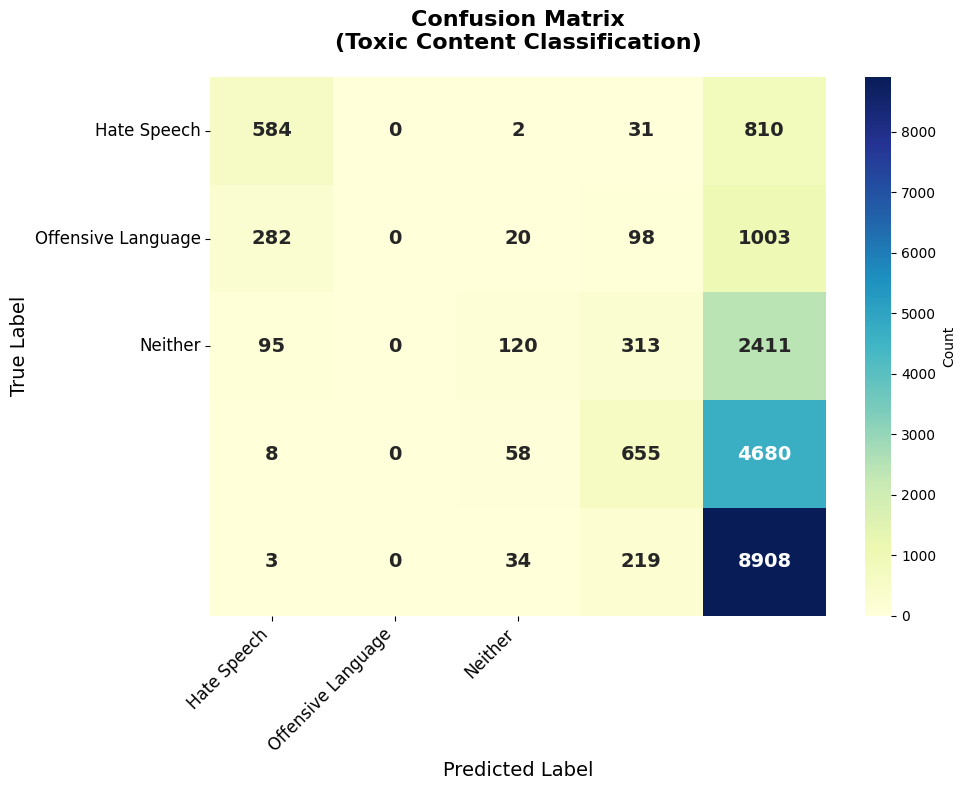

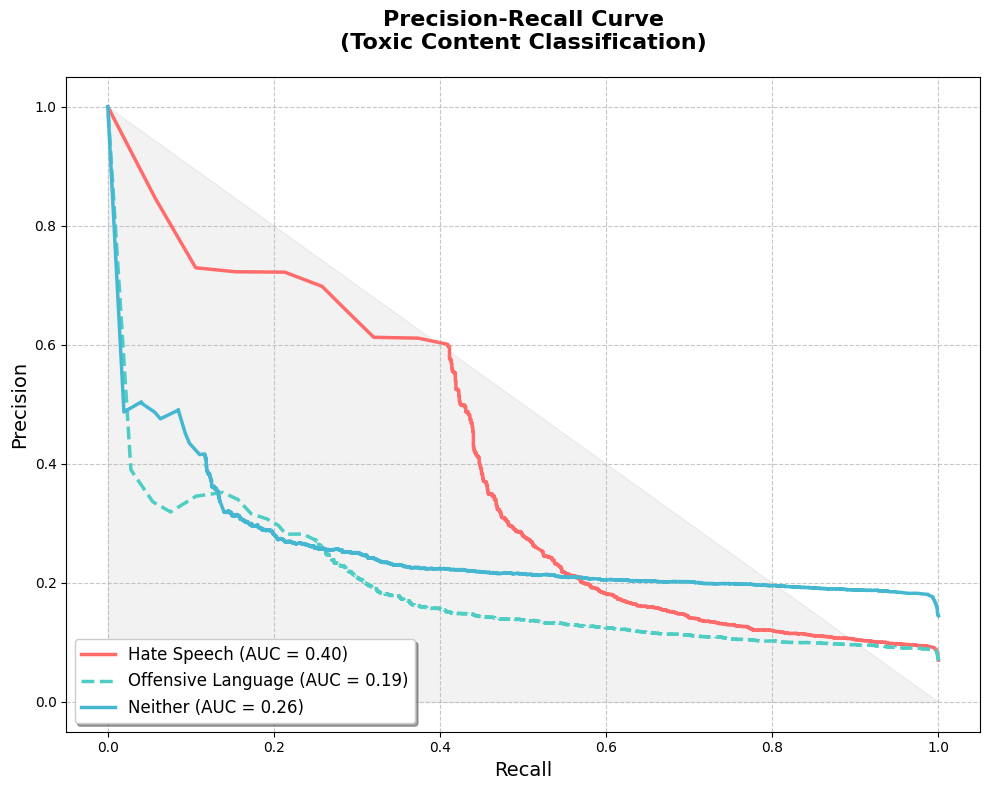

In [17]:
# Run testing
test_model(model)

In [10]:
import os
def interactive_classification(model):
    while True:
        sentence = input("\nEnter a sentence to classify (or 'exit' to stop): ")
        if sentence.lower() == "exit":
            break
        classify_sentence(sentence,model)

# Evaluate on test set
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask).logits
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    print(f"\nTest Accuracy: {accuracy:.4f}")



In [11]:
# Run evaluation and interactive classification
evaluate_model(model)
interactive_classification(model)


Test Accuracy: 0.0573



Enter a sentence to classify (or 'exit' to stop):  hello 



Input sentence: 'hello '
Applicability to each category:
Hate Speech (0): 0.4702
Offensive Language (1): 0.2986
Neither (2): 0.2313
Predicted class: Hate Speech (0)


Epoch 1/1: 100%|████████████| 543/543 [01:54<00:00,  4.73it/s, train_loss=0.321]


Epoch 1 - Train Loss: 0.3208, Val Loss: 0.2372, Val Accuracy: 0.9177


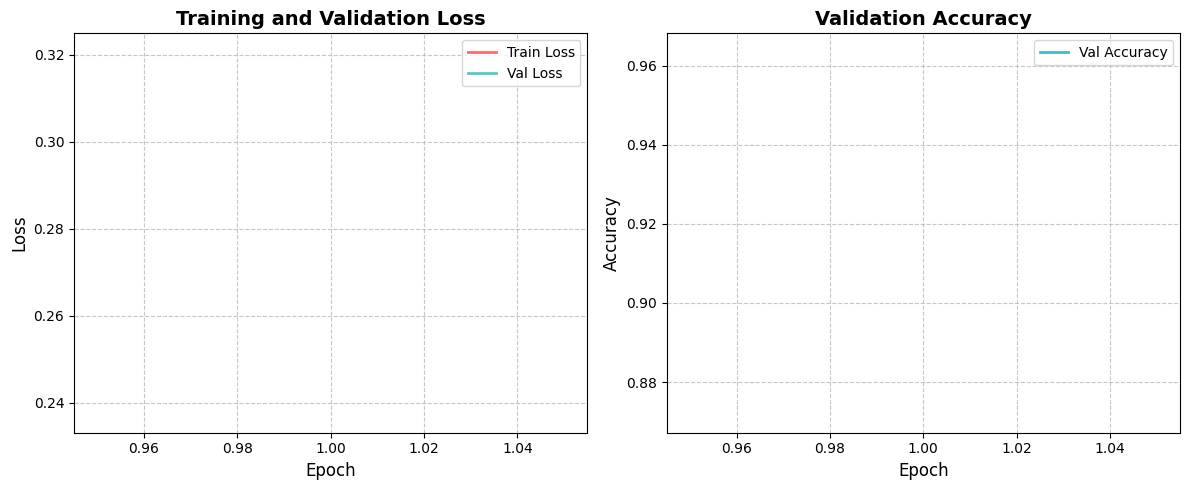

NameError: name 'finetunemodel' is not defined

In [12]:
from tqdm import tqdm

# Fine-tune with tqdm and validation
def fine_tune_model(model_path,max_epochs=5, patience=2):
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(max_epochs):
        # Training
        model.train()
        total_train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", leave=True)
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            loop.set_postfix(train_loss=total_train_loss / (loop.n + 1))
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                total_val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color="#FF6B6B", lw=2)
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss", color="#4ECDC4", lw=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training and Validation Loss", fontsize=14, weight="bold")
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Accuracy", color="#45B7D1", lw=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Validation Accuracy", fontsize=14, weight="bold")
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

    return   # Return number of epochs run
    
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "bestBert.pth")

fine_tune_model(model_path,max_epochs=1, patience=5)

In [13]:
model.load_state_dict(torch.load(model_path))
model.eval()
# Run evaluation and interactive classification
evaluate_model(model)
interactive_classification(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
# Function to count trainable parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to compute FLOPs (simplified)
def compute_flops(model):
    return count_params(model) * 2  # Rough estimate
compute_flops(model)

218969094

# UCB

In [3]:
data = pd.read_csv("dataset/RawUCB.csv")
model_dir ='models/BERT/UCB/'

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)  # 5-class model
# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)


In [8]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = [int(label) for label in labels]  # Convert float scores (0.0 to 4.0) to integers (0 to 4)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)  # 5-class labels
        }
# Testing mechanism
def test_model(model):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total = 0
    correct = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask).logits
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
            correct += (preds == labels.cpu().numpy()).sum()
            total += labels.size(0)
    
    # Calculate metrics
    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=[0, 1, 2])
    cm = confusion_matrix(all_labels, all_preds)
    
    # Print metrics
    class_names = ["Hate Speech", "Offensive Language", "Neither"]
    print(f"\nTest Accuracy: {accuracy:.4f}")
    for i, name in enumerate(class_names):
        print(f"\n{name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")

    # Fancy Confusion Matrix Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Count'},
                xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 14, "weight": "bold"})
    plt.title("Confusion Matrix\n(Toxic Content Classification)", fontsize=16, pad=20, weight="bold")
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

    # Fancy Precision-Recall Curve
    plt.figure(figsize=(10, 8))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Custom colors for each class
    for i, (name, color) in enumerate(zip(class_names, colors)):
        precision_curve, recall_curve, _ = precision_recall_curve(
            [1 if l == i else 0 for l in all_labels], 
            [p[i] for p in all_probs]
        )
        pr_auc = auc(recall_curve, precision_curve)
        plt.plot(recall_curve, precision_curve, label=f"{name} (AUC = {pr_auc:.2f})", 
                 color=color, lw=2.5, linestyle='-' if i % 2 == 0 else '--')
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title("Precision-Recall Curve\n(Toxic Content Classification)", fontsize=16, pad=20, weight="bold")
    plt.legend(loc="lower left", fontsize=12, frameon=True, shadow=True, facecolor="white")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.fill_between([0, 1], [1, 0], alpha=0.1, color="gray")
    plt.tight_layout()
    plt.show()

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load and prepare the dataset

# Extract relevant columns
comments = data["sentence"].tolist()
labels = data["label"].tolist()  # 'toxic' or 'non-toxic'
sentiment = data["sentiment"].tolist()  # Numerical (0.0 to 4.0)
respect = data["respect"].tolist()  # Numerical (0.0 to 4.0)
insult = data["insult"].tolist()  # Numerical (0.0 to 4.0)
humiliate = data["humiliate"].tolist()  # Numerical (0.0 to 4.0)
status = data["status"].tolist()  # Numerical (0.0 to 4.0)
dehumanize = data["dehumanize"].tolist()  # Numerical (0.0 to 4.0)
violence = data["violence"].tolist()  # Numerical (0.0 to 4.0)

# Check class distribution for binary label
print(f"Total samples: {len(comments)}")
print(f"Toxic: {sum(1 for l in labels if l == 'toxic')}")
print(f"Non-toxic: {sum(1 for l in labels if l == 'non-toxic')}")

# Check distribution for numerical attributes, filtering out None values
print("\nSentiment distribution:", {x: sentiment.count(x) for x in sorted(x for x in set(sentiment) if x is not None)})
print("Respect distribution:", {x: respect.count(x) for x in sorted(x for x in set(respect) if x is not None)})
print("Insult distribution:", {x: insult.count(x) for x in sorted(x for x in set(insult) if x is not None)})
print("Humiliate distribution:", {x: humiliate.count(x) for x in sorted(x for x in set(humiliate) if x is not None)})
print("Status distribution:", {x: status.count(x) for x in sorted(x for x in set(status) if x is not None)})
print("Dehumanize distribution:", {x: dehumanize.count(x) for x in sorted(x for x in set(dehumanize) if x is not None)})
print("Violence distribution:", {x: violence.count(x) for x in sorted(x for x in set(violence) if x is not None)})

# Split into train, validation, and test sets (stratified by binary label)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    comments, labels, test_size=0.3, stratify=labels, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
train_dataset = TweetDataset(train_texts, train_sentiment, tokenizer)
val_dataset = TweetDataset(val_texts, val_sentiment, tokenizer)
test_dataset = TweetDataset(test_texts, test_sentiment, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Run testing
test_model(model)

Total samples: 135556
Toxic: 120025
Non-toxic: 15531

Sentiment distribution: {0.0: 9658, 1.0: 9435, 2.0: 19785, 3.0: 35243, 4.0: 61435}
Respect distribution: {0.0: 12839, 1.0: 9629, 2.0: 23895, 3.0: 30720, 4.0: 58473}
Insult distribution: {0.0: 18476, 1.0: 14667, 2.0: 18587, 3.0: 39673, 4.0: 44153}
Humiliate distribution: {0.0: 21306, 1.0: 19555, 2.0: 25035, 3.0: 39382, 4.0: 30278}
Status distribution: {0.0: 1228, 1.0: 4261, 2.0: 61154, 3.0: 36413, 4.0: 32500}
Dehumanize distribution: {0.0: 31855, 1.0: 28434, 2.0: 25292, 3.0: 28653, 4.0: 21322}
Violence distribution: {0.0: 67922, 1.0: 30727, 2.0: 12241, 3.0: 11262, 4.0: 13404}


In [5]:


# Move to device
model.to(device)

# Zero-shot mechanism: Define hypotheses for each attribute (excluding label)
hypotheses = {
    "sentiment": [
        "This text expresses no sentiment (neutral, score 0).",
        "This text expresses slightly positive or negative sentiment (score 1).",
        "This text expresses moderate positive or negative sentiment (score 2).",
        "This text expresses strong positive or negative sentiment (score 3).",
        "This text expresses very strong positive or negative sentiment (score 4)."
    ],
    "respect": [
        "This text shows no respect for others (score 0).",
        "This text shows slight respect for others (score 1).",
        "This text shows moderate respect for others (score 2).",
        "This text shows strong respect for others (score 3).",
        "This text shows very strong respect for others (score 4)."
    ],
    "insult": [
        "This text contains no insults (score 0).",
        "This text contains mild insults (score 1).",
        "This text contains moderate insults (score 2).",
        "This text contains strong insults (score 3).",
        "This text contains very strong insults (score 4)."
    ],
    "humiliate": [
        "This text does not humiliate anyone (score 0).",
        "This text slightly humiliates someone (score 1).",
        "This text moderately humiliates someone (score 2).",
        "This text strongly humiliates someone (score 3).",
        "This text very strongly humiliates someone (score 4)."
    ],
    "status": [
        "This text does not reference social status (score 0).",
        "This text slightly references social status (score 1).",
        "This text moderately references social status (score 2).",
        "This text strongly references social status (score 3).",
        "This text very strongly references social status (score 4)."
    ],
    "dehumanize": [
        "This text does not dehumanize anyone (score 0).",
        "This text slightly dehumanizes someone (score 1).",
        "This text moderately dehumanizes someone (score 2).",
        "This text strongly dehumanizes someone (score 3).",
        "This text very strongly dehumanizes someone (score 4)."
    ],
    "violence": [
        "This text contains no references to violence (score 0).",
        "This text contains slight references to violence (score 1).",
        "This text contains moderate references to violence (score 2).",
        "This text contains strong references to violence (score 3).",
        "This text contains very strong references to violence (score 4)."
    ]
}

# Function to classify an input sentence using zero-shot for all attributes
def classify_sentence(sentence, model):
    model.eval()
    for attribute, hyp_list in hypotheses.items():
        print(f"\nClassifying for {attribute.upper()}:")
        inputs = tokenizer([f"{sentence} [SEP] {hyp}" for hyp in hyp_list], 
                          padding=True, truncation=True, max_length=128, return_tensors="pt")
        inputs = {key: val.to(device) for key, val in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs).logits
            probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]  # Probabilities for 5 classes
        
        print(f"Input sentence: '{sentence}'")
        print("Applicability to each category:")
        class_names = [f"Score {i} ({i})" for i in range(len(hyp_list))]
        for i, (prob, hyp) in enumerate(zip(probs, hyp_list)):
            print(f"{class_names[i]}: {prob:.4f} - {hyp}")
        predicted_class = np.argmax(probs)
        print(f"Predicted class: {class_names[predicted_class]} - {hyp_list[predicted_class]}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def interactive_classification(model):
    while True:
        sentence = input("\nEnter a sentence to classify (or 'exit' to stop): ")
        if sentence.lower() == "exit":
            break
        classify_sentence(sentence,model)
interactive_classification(model)


Enter a sentence to classify (or 'exit' to stop):  dfsjhiujfh



Classifying for SENTIMENT:
Input sentence: 'dfsjhiujfh'
Applicability to each category:
Score 0 (0): 0.2364
Score 1 (1): 0.0854
Score 2 (2): 0.2814
Score 3 (3): 0.2142
Score 4 (4): 0.1826
Predicted class: Score 2 (2)

Classifying for RESPECT:
Input sentence: 'dfsjhiujfh'
Applicability to each category:
Score 0 (0): 0.2429
Score 1 (1): 0.0896
Score 2 (2): 0.2686
Score 3 (3): 0.2199
Score 4 (4): 0.1790
Predicted class: Score 2 (2)

Classifying for INSULT:
Input sentence: 'dfsjhiujfh'
Applicability to each category:
Score 0 (0): 0.2463
Score 1 (1): 0.0841
Score 2 (2): 0.2779
Score 3 (3): 0.2086
Score 4 (4): 0.1831
Predicted class: Score 2 (2)

Classifying for HUMILIATE:
Input sentence: 'dfsjhiujfh'
Applicability to each category:
Score 0 (0): 0.2369
Score 1 (1): 0.0894
Score 2 (2): 0.2662
Score 3 (3): 0.2227
Score 4 (4): 0.1847
Predicted class: Score 2 (2)

Classifying for STATUS:
Input sentence: 'dfsjhiujfh'
Applicability to each category:
Score 0 (0): 0.2506
Score 1 (1): 0.0823
Score 2


Enter a sentence to classify (or 'exit' to stop):  fuck me



Classifying for SENTIMENT:
Input sentence: 'fuck me'
Applicability to each category:
Score 0 (0): 0.2618
Score 1 (1): 0.0817
Score 2 (2): 0.2777
Score 3 (3): 0.1825
Score 4 (4): 0.1962
Predicted class: Score 2 (2)

Classifying for RESPECT:
Input sentence: 'fuck me'
Applicability to each category:
Score 0 (0): 0.2580
Score 1 (1): 0.0848
Score 2 (2): 0.2623
Score 3 (3): 0.2136
Score 4 (4): 0.1814
Predicted class: Score 2 (2)

Classifying for INSULT:
Input sentence: 'fuck me'
Applicability to each category:
Score 0 (0): 0.2604
Score 1 (1): 0.0823
Score 2 (2): 0.2700
Score 3 (3): 0.1938
Score 4 (4): 0.1936
Predicted class: Score 2 (2)

Classifying for HUMILIATE:
Input sentence: 'fuck me'
Applicability to each category:
Score 0 (0): 0.2679
Score 1 (1): 0.0837
Score 2 (2): 0.2616
Score 3 (3): 0.2172
Score 4 (4): 0.1696
Predicted class: Score 0 (0)

Classifying for STATUS:
Input sentence: 'fuck me'
Applicability to each category:
Score 0 (0): 0.2638
Score 1 (1): 0.0821
Score 2 (2): 0.2741
Sc


Enter a sentence to classify (or 'exit' to stop):  exit


In [9]:

# Fine-tune with tqdm and validation
def fine_tune_model(model, train_loader, val_loader, model_path, max_epochs=5, patience=2):
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(max_epochs):
        # Training
        model.train()
        total_train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", leave=True)
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            loop.set_postfix(train_loss=total_train_loss / (loop.n + 1))
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                total_val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color="#FF6B6B", lw=2)
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss", color="#4ECDC4", lw=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training and Validation Loss", fontsize=14, weight="bold")
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Accuracy", color="#45B7D1", lw=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Validation Accuracy", fontsize=14, weight="bold")
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, "training_metrics_sentiment.png"))  # Save plot

    return len(train_losses)  # Return number of epochs run


Epoch 1/1: 100%|███████████| 2966/2966 [11:04<00:00,  4.46it/s, train_loss=1.17]


Epoch 1 - Train Loss: 1.1726, Val Loss: 1.1355, Val Accuracy: 0.5061


1

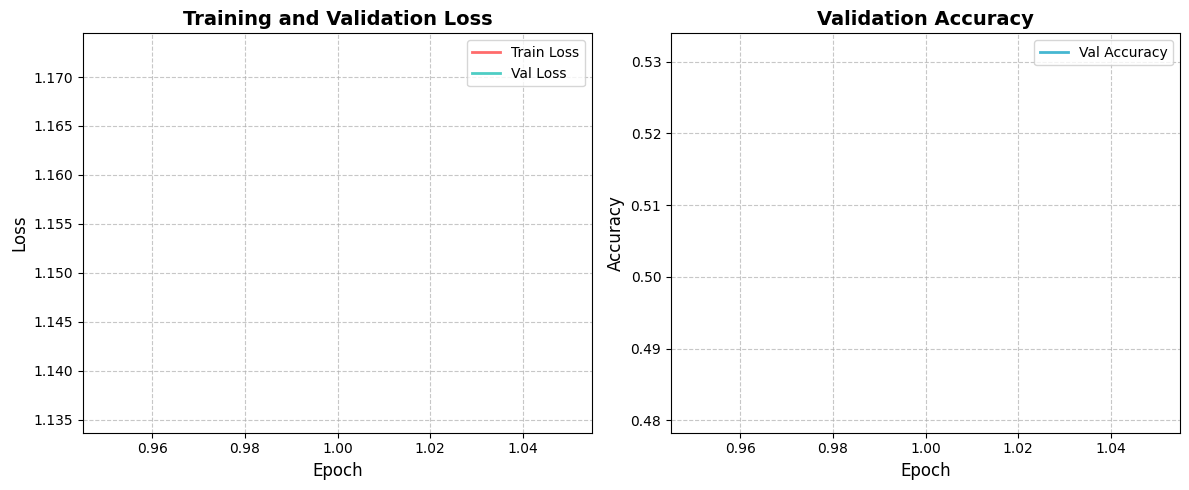

In [11]:
import os
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "bestBert.pth")

# Run fine-tuning
fine_tune_model(model, train_loader, val_loader, model_path, max_epochs=1, patience=5)

In [12]:
model.load_state_dict(torch.load(model_path))
model.eval()
# Run evaluation and interactive classification
interactive_classification(model)


Enter a sentence to classify (or 'exit' to stop):  are you stupiud



Classifying for SENTIMENT:
Input sentence: 'are you stupiud'
Applicability to each category:
Score 0 (0): 0.0594
Score 1 (1): 0.0752
Score 2 (2): 0.1836
Score 3 (3): 0.3090
Score 4 (4): 0.3727
Predicted class: Score 4 (4)

Classifying for RESPECT:
Input sentence: 'are you stupiud'
Applicability to each category:
Score 0 (0): 0.0583
Score 1 (1): 0.0735
Score 2 (2): 0.1813
Score 3 (3): 0.3062
Score 4 (4): 0.3808
Predicted class: Score 4 (4)

Classifying for INSULT:
Input sentence: 'are you stupiud'
Applicability to each category:
Score 0 (0): 0.0607
Score 1 (1): 0.0764
Score 2 (2): 0.1843
Score 3 (3): 0.3072
Score 4 (4): 0.3714
Predicted class: Score 4 (4)

Classifying for HUMILIATE:
Input sentence: 'are you stupiud'
Applicability to each category:
Score 0 (0): 0.0588
Score 1 (1): 0.0746
Score 2 (2): 0.1827
Score 3 (3): 0.3074
Score 4 (4): 0.3765
Predicted class: Score 4 (4)

Classifying for STATUS:
Input sentence: 'are you stupiud'
Applicability to each category:
Score 0 (0): 0.0582
Sc


Enter a sentence to classify (or 'exit' to stop):  are you ok



Classifying for SENTIMENT:
Input sentence: 'are you ok'
Applicability to each category:
Score 0 (0): 0.0530
Score 1 (1): 0.0710
Score 2 (2): 0.1791
Score 3 (3): 0.3183
Score 4 (4): 0.3787
Predicted class: Score 4 (4)

Classifying for RESPECT:
Input sentence: 'are you ok'
Applicability to each category:
Score 0 (0): 0.0505
Score 1 (1): 0.0681
Score 2 (2): 0.1755
Score 3 (3): 0.3166
Score 4 (4): 0.3893
Predicted class: Score 4 (4)

Classifying for INSULT:
Input sentence: 'are you ok'
Applicability to each category:
Score 0 (0): 0.0523
Score 1 (1): 0.0699
Score 2 (2): 0.1777
Score 3 (3): 0.3191
Score 4 (4): 0.3810
Predicted class: Score 4 (4)

Classifying for HUMILIATE:
Input sentence: 'are you ok'
Applicability to each category:
Score 0 (0): 0.0517
Score 1 (1): 0.0697
Score 2 (2): 0.1780
Score 3 (3): 0.3181
Score 4 (4): 0.3826
Predicted class: Score 4 (4)

Classifying for STATUS:
Input sentence: 'are you ok'
Applicability to each category:
Score 0 (0): 0.0490
Score 1 (1): 0.0663
Score 2

KeyboardInterrupt: Interrupted by user

In [13]:
test_model(model)

NameError: name 'test_model' is not defined